In [1]:
#importing libraries
import pandas as pd 
import sqlite3
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
#sql wrapper
def rsql(query):
    return pd.read_sql_query(query,conn)

In [3]:
#import data as dataframe
df = pd.read_csv('Customer_Details.csv')

In [4]:
#extracting data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   invoice_no      99457 non-null  object 
 1   customer_id     99457 non-null  object 
 2   gender          99457 non-null  object 
 3   age             99457 non-null  int64  
 4   category        99457 non-null  object 
 5   quantity        99457 non-null  int64  
 6   price           99457 non-null  float64
 7   payment_method  99457 non-null  object 
 8   invoice_date    99457 non-null  object 
 9   shopping_mall   99457 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 7.6+ MB


In [5]:
#creating a df with unique customers
customer_df = df[['customer_id', 'gender','age']].drop_duplicates().reset_index(drop=True)
customer_df

,customer_id,gender,age
0,C241288,Female,28
1,C111565,Male,21
2,C266599,Male,20
3,C988172,Female,66
4,C189076,Female,53
...,...,...,...
99452,C441542,Female,45
99453,C569580,Male,27
99454,C103292,Male,63
99455,C800631,Male,56


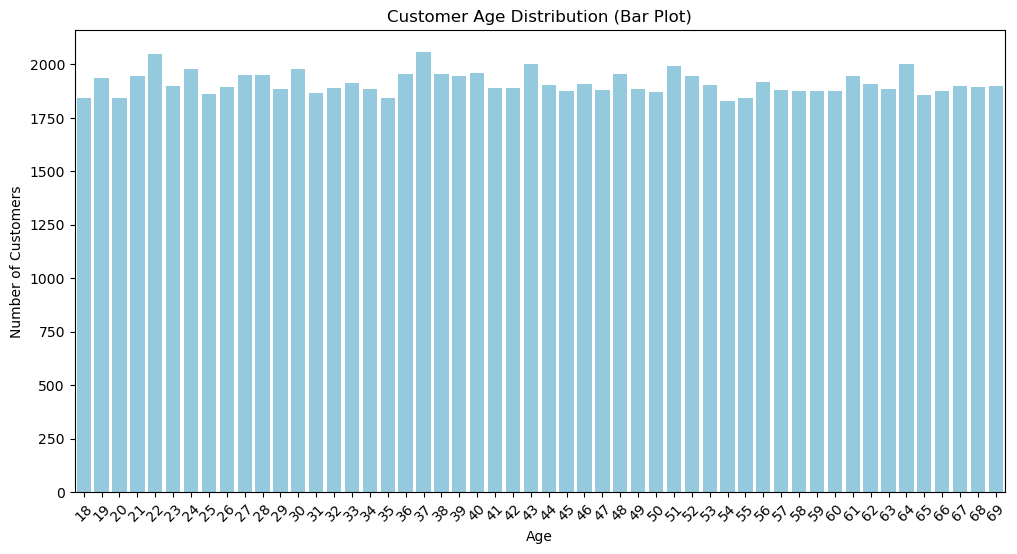

In [6]:
#Age Distribution barplot 
age_counts = customer_df['age'].value_counts().sort_index()

plt.figure(figsize=(12,6))
sns.barplot(x=age_counts.index, y=age_counts.values, color='skyblue')
plt.title('Customer Age Distribution (Bar Plot)')
plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

In [7]:
#creating a product table from original dataframe for sql
product_df= df[['category']].reset_index()
product_df.rename(columns={'index':'product_id'},inplace =True)
product_df

,product_id,category
0,0,Clothing
1,1,Shoes
2,2,Clothing
3,3,Shoes
4,4,Books
...,...,...
99452,99452,Souvenir
99453,99453,Food & Beverage
99454,99454,Food & Beverage
99455,99455,Technology


In [8]:
#creating an invoices df from original dataframe for sql
invoices_df = df[['invoice_no','customer_id','invoice_date','payment_method','shopping_mall']].drop_duplicates().reset_index(drop=True)
invoices_df.rename(columns = {'shopping_mall' : 'mall_name'}, inplace = True)
invoices_df

,invoice_no,customer_id,invoice_date,payment_method,mall_name
0,I138884,C241288,05-08-2022,Credit Card,Kanyon
1,I317333,C111565,12-12-2021,Debit Card,Forum Istanbul
2,I127801,C266599,09-11-2021,Cash,Metrocity
3,I173702,C988172,16-05-2021,Credit Card,Metropol AVM
4,I337046,C189076,24-10-2021,Cash,Kanyon
...,...,...,...,...,...
99452,I219422,C441542,21-09-2022,Credit Card,Kanyon
99453,I325143,C569580,22-09-2021,Cash,Forum Istanbul
99454,I824010,C103292,28-03-2021,Debit Card,Metrocity
99455,I702964,C800631,16-03-2021,Cash,Istinye Park


In [9]:
#creating invoice detail table from original dataframe for sql
invoices_detail_df = df[['invoice_no','quantity','price']].reset_index()
invoices_detail_df.rename(columns={'index':'product_id'},inplace =True)
invoices_detail_df

,product_id,invoice_no,quantity,price
0,0,I138884,5,1500.40
1,1,I317333,3,1800.51
2,2,I127801,1,300.08
3,3,I173702,5,3000.85
4,4,I337046,4,60.60
...,...,...,...,...
99452,99452,I219422,5,58.65
99453,99453,I325143,2,10.46
99454,99454,I824010,2,10.46
99455,99455,I702964,4,4200.00


In [10]:
#creating a connection to database
conn = sqlite3.connect('Customers_Detail.db')
#creating a cursor
c = conn.cursor()

In [11]:
#printing each df's column names
print(customer_df .columns)
print(product_df.columns)
print(invoices_df.columns)
print(invoices_detail_df.columns)

Index(['customer_id', 'gender', 'age'], dtype='object')
Index(['product_id', 'category'], dtype='object')
Index(['invoice_no', 'customer_id', 'invoice_date', 'payment_method',
       'mall_name'],
      dtype='object')
Index(['product_id', 'invoice_no', 'quantity', 'price'], dtype='object')


In [12]:
#creating a customer table
c.execute("""CREATE TABLE IF NOT EXISTS customer ('customer_id' TEXT PRIMARY KEY UNIQUE,
'gender' TEXT, 'age' TEXT);""")

In [13]:
#creating a product table 
c.execute("""CREATE TABLE IF NOT EXISTS product('product_id' TEXT PRIMARY KEY UNIQUE,
'category' TEXT);""")

In [14]:
#creating an order table
c.execute("""CREATE TABLE IF NOT EXISTS invoices('invoice_no' TEXT PRIMARY KEY UNIQUE,
'customer_id' TEXT, 'invoice_date' TEXT, 'payment_method' INT,'mall_name' TEXT,
FOREIGN KEY (customer_id) REFERENCES customer(customer_id));""")

In [15]:
#creating a sales table
c.execute("""CREATE TABLE IF NOT EXISTS invoices_detail('product_id' TEXT,'invoice_no' TEXT
'quantity' int, 'price' int,
FOREIGN KEY (product_id) REFERENCES product(product_id),
FOREIGN KEY (invoice_no) REFERENCES invoices(invoice_no));""")

In [16]:
#uploading the data into their respective tables 
customer_df.to_sql('customer',conn ,if_exists = 'replace' ,index = False)
product_df.to_sql('product',conn ,if_exists = 'replace' ,index = False)
invoices_df.to_sql('invoices',conn ,if_exists = 'replace' ,index = False)
invoices_detail_df.to_sql('invoices_detail',conn ,if_exists = 'replace' ,index = False)

99457

#### 1. What is the total spending of each customer along with their age and gender?

##### Purpose: To calculate total purchases per customer for analyzing spending patterns across different ages and genders.

In [18]:
rsql("""SELECT c.customer_id,c.age,c.gender, SUM(id.price * id.quantity) AS total_spent
FROM customer c JOIN invoices i ON c.customer_id = i.customer_id
JOIN invoices_detail id ON i.invoice_no = id.invoice_no
GROUP BY c.customer_id""")

,customer_id,age,gender,total_spent
0,C100004,61,Male,7502.00
1,C100005,34,Male,2400.68
2,C100006,44,Male,322.56
3,C100012,25,Male,130.75
4,C100019,21,Female,35.84
...,...,...,...,...
99452,C999886,61,Male,47.07
99453,C999910,41,Male,136.35
99454,C999974,29,Female,7502.00
99455,C999976,49,Female,322.56


#### 2. Find the total revenue generated by each mall and rank them from highest to lowest.

##### Purpose: To rank malls by total sales value and identify the top-performing locations.

In [20]:
rsql(""" SELECT i.mall_name, SUM(id.price * id.quantity) AS total_revenue
FROM invoices i JOIN invoices_detail id ON i.invoice_no = id.invoice_no
GROUP BY i.mall_name
ORDER BY total_revenue DESC;""")

,mall_name,total_revenue
0,Mall of Istanbul,5.087248e+07
1,Kanyon,5.055423e+07
2,Metrocity,3.730279e+07
3,Metropol AVM,2.537991e+07
4,Istinye Park,2.461883e+07
5,Zorlu Center,1.290105e+07
6,Cevahir AVM,1.264514e+07
7,Viaport Outlet,1.252134e+07
8,Emaar Square Mall,1.240610e+07
9,Forum Istanbul,1.230392e+07


#### 3. Which are the top three product categories by total revenue?

##### Purpose: Understand which product categories contribute the most to overall sales revenue.

In [22]:
rsql("""SELECT p.category, SUM(id.price * id.quantity) AS total_revenue
FROM product p JOIN invoices_detail id ON p.product_id = id.product_id
GROUP BY p.category
ORDER BY total_revenue DESC
LIMIT 3""")

,category,total_revenue
0,Clothing,1.139968e+08
1,Shoes,6.655345e+07
2,Technology,5.786235e+07


#### 4. Which product categories generate the highest revenue for each gender?

##### Purpose: To analyze sales data to compare which product categories are most profitable or popular among different genders.

In [24]:
rsql("""SELECT c.customer_id,c.gender, p.category, SUM(id.price * id.quantity) AS revenue
FROM customer c JOIN invoices i ON c.customer_id = i.customer_id
JOIN invoices_detail id ON i.invoice_no = id.invoice_no
JOIN product p ON id.product_id = p.product_id
GROUP BY c.gender, p.category
ORDER BY revenue DESC """)

,customer_id,gender,category,revenue
0,C241288,Female,Clothing,6.825170e+07
1,C266599,Male,Clothing,4.574510e+07
2,C988172,Female,Shoes,3.942517e+07
3,C626042,Female,Technology,3.466995e+07
4,C111565,Male,Shoes,2.712828e+07
5,C313348,Male,Technology,2.319240e+07
6,C151197,Female,Cosmetics,4.066773e+06
7,C251229,Male,Cosmetics,2.726090e+06
8,C225330,Female,Toys,2.416046e+06
9,C196845,Male,Toys,1.564380e+06


#### 5. Who are the top five customers by total spending?

##### Purpose: Identify the most valuable customers based on their overall purchase amount.

In [26]:
rsql("""SELECT c.customer_id,SUM(id.price * id.quantity) AS total_spent
FROM customer c JOIN invoices i ON c.customer_id = i.customer_id
JOIN invoices_detail id ON i.invoice_no = id.invoice_no
GROUP BY c.customer_id
ORDER BY total_spent DESC
LIMIT 5""")

,customer_id,total_spent
0,C998781,26250.0
1,C991315,26250.0
2,C988230,26250.0
3,C987359,26250.0
4,C986474,26250.0


#### 6. Which product category sold the highest quantity overall?
##### Purpose: To understand demand trends and consumer preferences across all categories.

In [28]:
rsql("""SELECT p.category,SUM(id.quantity) AS total_quantity_sold
FROM product p JOIN invoices_detail id ON p.product_id = id.product_id
GROUP BY p.category
ORDER BY total_quantity_sold DESC
LIMIT 1""")

,category,total_quantity_sold
0,Clothing,103558


#### 7.What is the average number of items purchased per invoice for each mall?

##### Purpose: To identify shopping behavior patterns, for eg.: whether customers at certain malls tend to make larger or smaller purchases per visit.

In [30]:
rsql("""SELECT i.mall_name,AVG(id.quantity) AS avg_items_per_invoice
FROM invoices i JOIN invoices_detail id ON i.invoice_no = id.invoice_no
GROUP BY i.mall_name""")

,mall_name,avg_items_per_invoice
0,Cevahir AVM,2.995191
1,Emaar Square Mall,3.014134
2,Forum Istanbul,3.002224
3,Istinye Park,3.012473
4,Kanyon,2.999395
5,Mall of Istanbul,3.014291
6,Metrocity,2.990740
7,Metropol AVM,3.004626
8,Viaport Outlet,2.994709
9,Zorlu Center,3.001773


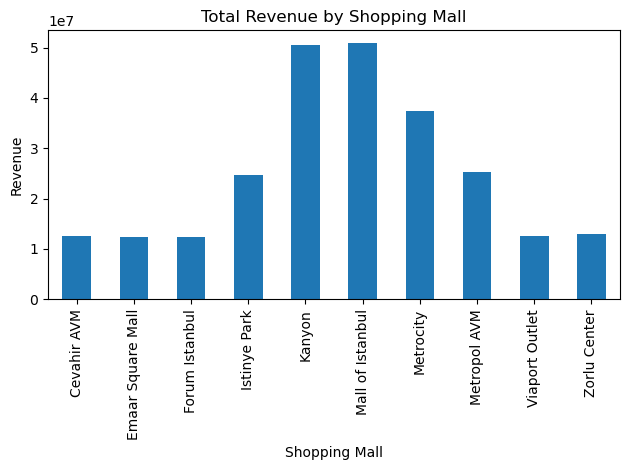

In [31]:
#Total Revenue by Shopping Mall
(df['quantity'] * df['price']).groupby(df['shopping_mall']).sum().plot(kind='bar')
plt.title('Total Revenue by Shopping Mall')
plt.xlabel('Shopping Mall')
plt.ylabel('Revenue')
plt.tight_layout()
plt.show()

#### 8.Which customers under the age of 25 have purchased books?

##### Purpose: Analyze purchasing patterns among younger demographic segments, specifically regarding their interest in books.

In [33]:
rsql("""SELECT DISTINCT c.customer_id , c.age ,p.category
FROM customer c JOIN invoices i ON c.customer_id = i.customer_id
JOIN invoices_detail id ON i.invoice_no = id.invoice_no
JOIN product p ON id.product_id = p.product_id
WHERE c.age < 25 AND p.category = 'Books'""")

,customer_id,age,category
0,C653385,22,Books
1,C820515,22,Books
2,C310642,24,Books
3,C131497,21,Books
4,C270667,22,Books
...,...,...,...
682,C202206,19,Books
683,C927132,19,Books
684,C253031,21,Books
685,C152292,23,Books


#### 9.What is the total quantity sold for each product category by payment method?

##### Purpose: To analyze purchasing trends by linking product categories with customers’ preferred payment methods.

In [35]:
rsql("""SELECT i.payment_method,p.category,SUM(id.quantity) AS total_quantity
FROM invoices i JOIN invoices_detail id ON i.invoice_no = id.invoice_no
JOIN product p ON id.product_id = p.product_id
GROUP BY i.payment_method, p.category
ORDER BY i.payment_method, total_quantity DESC""")

,payment_method,category,total_quantity
0,Cash,Clothing,46542
1,Cash,Cosmetics,19931
2,Cash,Food & Beverage,19623
3,Cash,Toys,13745
4,Cash,Shoes,13492
5,Cash,Books,6831
6,Cash,Technology,6720
7,Cash,Souvenir,6486
8,Credit Card,Clothing,35877
9,Credit Card,Cosmetics,16283


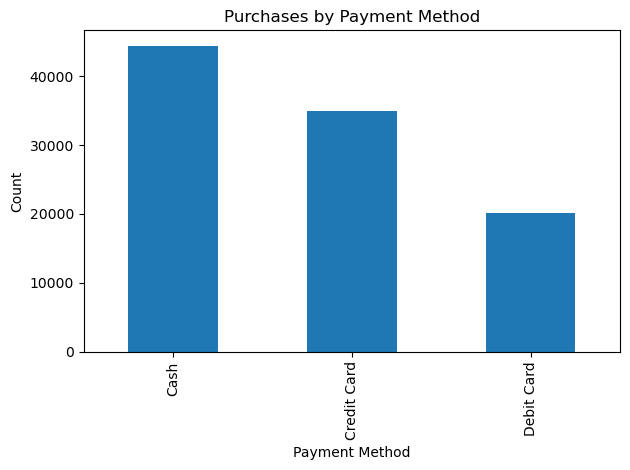

In [36]:
#No. of purchases by payemnt method
df['payment_method'].value_counts().plot(kind='bar')
plt.title('Purchases by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

#### 10.What is the average number of items purchased per invoice for each gender?

##### Purpose: To understand purchasing behavior differences between male and female customers in terms of item quantity per transaction.

In [38]:
rsql("""SELECT c.gender,AVG(id.quantity) AS avg_items_per_invoice
FROM customer c JOIN invoices i ON c.customer_id = i.customer_id
JOIN invoices_detail id ON i.invoice_no = id.invoice_no
GROUP BY c.gender""")

,gender,avg_items_per_invoice
0,Female,3.003581
1,Male,3.003202


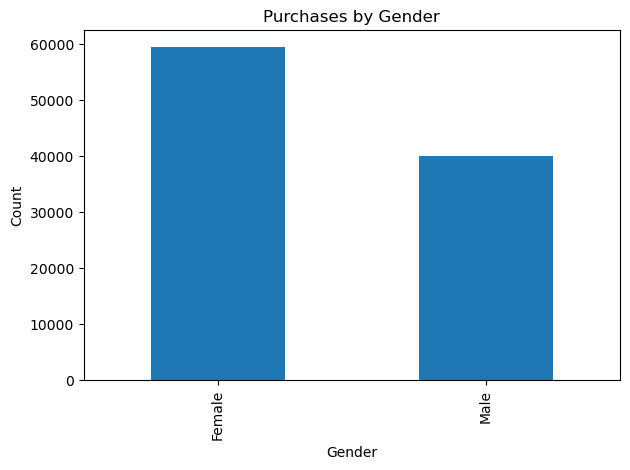

In [39]:
#Purchases per gender 
df['gender'].value_counts().plot(kind='bar')
plt.title('Purchases by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

#### 11.Which product category has the highest average price per item?

##### Purpose: To understand pricing strategies and how they differ between product categories.

In [41]:
rsql("""SELECT p.category,AVG(id.price) AS avg_price
FROM product p JOIN invoices_detail id ON p.product_id = id.product_id
GROUP BY p.category
ORDER BY avg_price DESC""")

,category,avg_price
0,Technology,3156.935548
1,Shoes,1807.388568
2,Clothing,901.084021
3,Cosmetics,122.448626
4,Toys,107.733185
5,Books,45.568621
6,Souvenir,34.894345
7,Food & Beverage,15.671948


#### 12.What is the total number of items and total revenue for each invoice?

##### Purpose: To summarize sales at the invoice level by calculating the total quantity of items sold and the total revenue per transaction

In [43]:
rsql("""SELECT i.invoice_no,SUM(id.quantity) AS total_items,SUM(id.quantity * id.price) AS total_revenue
FROM invoices i JOIN invoices_detail id ON i.invoice_no = id.invoice_no
GROUP BY i.invoice_no;""")

,invoice_no,total_items,total_revenue
0,I100008,5,7502.00
1,I100014,5,1016.50
2,I100015,2,1200.32
3,I100024,3,136.35
4,I100027,4,16800.00
...,...,...,...
99452,I999956,4,573.44
99453,I999959,4,4801.28
99454,I999972,2,4200.00
99455,I999973,1,1050.00


#### 13.Find total number of distinct customers who purchased each product category.

##### Purpose: To understand customer interest and popularity of categories, beyond just sales volume or revenue.

In [45]:
rsql("""SELECT p.category,COUNT(DISTINCT i.customer_id) AS unique_customers
FROM product p JOIN invoices_detail id ON p.product_id = id.product_id
JOIN invoices i ON id.invoice_no = i.invoice_no
GROUP BY p.category;""")

,category,unique_customers
0,Books,4981
1,Clothing,34487
2,Cosmetics,15097
3,Food & Beverage,14776
4,Shoes,10034
5,Souvenir,4999
6,Technology,4996
7,Toys,10087


#### 14.Find the total number of invoices generated each day.

##### Purpose: To identify sales trends over time, such as peak and low transaction days.

In [47]:
rsql("""SELECT 
    invoice_date,
    COUNT(DISTINCT invoice_no) AS total_invoices
FROM invoices 
GROUP BY invoice_date""")

,invoice_date,total_invoices
0,01-01-2021,105
1,01-01-2022,101
2,01-01-2023,145
3,01-02-2021,105
4,01-02-2022,117
...,...,...
792,31-08-2022,115
793,31-10-2021,123
794,31-10-2022,126
795,31-12-2021,127


#### 15.Which product category has the highest total quantity sold per mall?

##### Purpose: To understand demand patterns across different malls, revealing which categories are most popular in specific locations.

In [49]:
rsql("""SELECT 
    i.mall_name,
    p.category,
    SUM(id.quantity) AS total_quantity
FROM invoices i
JOIN invoices_detail id ON i.invoice_no = id.invoice_no
JOIN product p ON id.product_id = p.product_id
GROUP BY i.mall_name, p.category
ORDER BY i.mall_name, total_quantity DESC""")

,mall_name,category,total_quantity
0,Cevahir AVM,Clothing,5180
1,Cevahir AVM,Food & Beverage,2293
2,Cevahir AVM,Cosmetics,2174
3,Cevahir AVM,Toys,1549
4,Cevahir AVM,Shoes,1473
...,...,...,...
75,Zorlu Center,Shoes,1589
76,Zorlu Center,Toys,1526
77,Zorlu Center,Books,809
78,Zorlu Center,Technology,765
